# **Keras code for CIFAR10 classification by CNN**

This simple CNN generates about 36% test accuracy for 100 training epochs.

### **Colab mount drive**

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')
root_dir = '/content/gdrive/My Drive/cifar10'

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


### **Import Keras necessary package**

> Indented block



In [0]:
import os

import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D, Activation, MaxPooling2D, BatchNormalization, Dropout, Flatten, Dense
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adagrad, RMSprop, SGD
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler
from tensorflow.keras.models import load_model
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.utils import to_categorical, model_to_dot
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from IPython.display import SVG

### **Define all settings**

In [0]:
num_classes = 10
data_augmentation = True

In [0]:
save_dir = os.path.join(os.getcwd(), 'saved_models')
model_name = 'keras_cifar10_trained_model.h5'

if not os.path.isdir(save_dir):
   os.makedirs(save_dir)

model_path = os.path.join(save_dir, model_name)

### **The data, split between train and test sets:**

In [5]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

x_train.shape, x_test.shape

((50000, 32, 32, 3), (10000, 32, 32, 3))

### **Convert class vectors to binary class matrices.**

In [6]:
y_train = to_categorical(y_train, num_classes)
y_test = to_categorical(y_test, num_classes)

y_train.shape, y_test.shape

((50000, 10), (10000, 10))

### **Define CNN architecture**

In [0]:
model = Sequential()
model.add(Conv2D(16, kernel_size=(3,3), padding='same', activation='relu', kernel_regularizer=l2(1e-4), input_shape=x_train.shape[1:]))
model.add(BatchNormalization())
model.add(Conv2D(16, kernel_size=(3,3), padding='same', activation='relu', kernel_regularizer=l2(1e-4)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.1))
 
model.add(Conv2D(32, kernel_size=(3,3), padding='same', activation='relu', kernel_regularizer=l2(1e-4)))
model.add(BatchNormalization())
model.add(Conv2D(32, kernel_size=(3,3), padding='same', activation='relu', kernel_regularizer=l2(1e-4)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))
 
model.add(Conv2D(64, kernel_size=(3,3), padding='same', activation='relu', kernel_regularizer=l2(1e-4)))
model.add(BatchNormalization())
model.add(Conv2D(64, kernel_size=(3,3), padding='same', activation='relu', kernel_regularizer=l2(1e-4)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.3))
 
model.add(Flatten())
model.add(Dense(num_classes, activation='softmax'))

### **Model compilation**

In [17]:
lr = 0.001
decay = 1e-6

optimizer = RMSprop(lr=lr, decay=decay)
model.compile(loss='categorical_crossentropy',
              optimizer=optimizer,
              metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 16)        448       
_________________________________________________________________
batch_normalization (BatchNo (None, 32, 32, 16)        64        
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 16)        2320      
_________________________________________________________________
batch_normalization_1 (Batch (None, 32, 32, 16)        64        
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 16)        0         
_________________________________________________________________
dropout (Dropout)            (None, 16, 16, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 32)        4

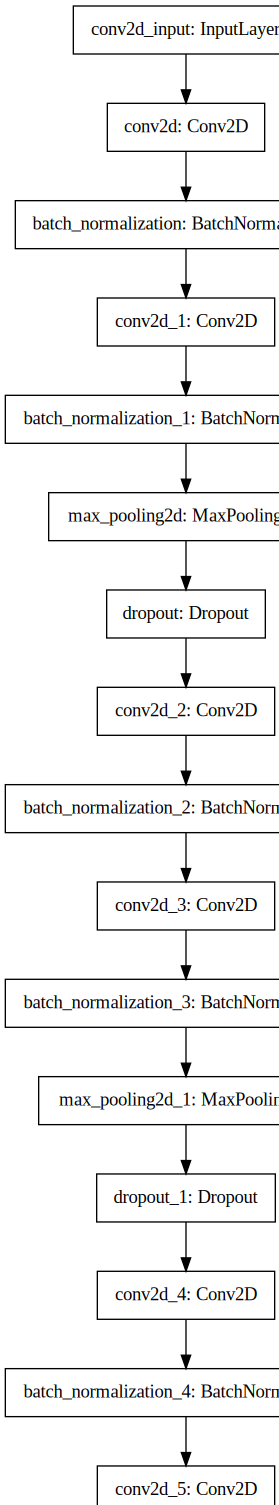

In [21]:
SVG(model_to_dot(model).create(prog='dot', format='svg'))

### **Data augmentation**

In [9]:
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255

#z-score
mean = np.mean(x_train,axis=(0,1,2,3))
std = np.std(x_train,axis=(0,1,2,3))
x_train = (x_train-mean)/(std+1e-7)
x_test = (x_test-mean)/(std+1e-7)

if not data_augmentation:
    print('Not using data augmentation.')
    model.fit(x_train, y_train,
              batch_size=batch_size,
              epochs=epochs,
              validation_data=(x_test, y_test),
              shuffle=True)
else:
    print('Using real-time data augmentation.')
    # datagen = ImageDataGenerator(
    #     featurewise_center=True,
    #     featurewise_std_normalization=True,
    #     #rotation_range=20,
    #     #width_shift_range=0.2,
    #     #height_shift_range=0.2,
    #     #horizontal_flip=True,
    # )

    datagen = ImageDataGenerator(
        rotation_range=15,
        width_shift_range=0.1,
        height_shift_range=0.1,
        horizontal_flip=True,
    )

    datagen.fit(x_train)

x_train.shape, x_test.shape

Using real-time data augmentation.


((50000, 32, 32, 3), (10000, 32, 32, 3))

### **Train the model**

In [0]:
def lr_schedule(epoch):
    lrate = lr
    if epoch > 50:
        lrate = 0.0005
    if epoch > 75:
        lrate = 0.0003
    return lrate

In [11]:
batch_size = 64
epochs = 100

model_checkpoint = ModelCheckpoint(model_path, verbose=1, monitor='val_accuracy',save_best_only=True, mode='auto') 
model.fit(datagen.flow(x_train, y_train,
                batch_size=batch_size),
            steps_per_epoch=x_train.shape[0]//batch_size,
            epochs=epochs,
            callbacks=[model_checkpoint, LearningRateScheduler(lr_schedule)],
            validation_data=(x_test, y_test),
            workers=1,)

Epoch 1/100
781/781 [==============================] - ETA: 0s - loss: 1.8125 - accuracy: 0.4069
Epoch 00001: val_accuracy improved from -inf to 0.52130, saving model to /content/saved_models/keras_cifar10_trained_model.h5
781/781 [==============================] - 35s 45ms/step - loss: 1.8125 - accuracy: 0.4069 - val_loss: 1.4172 - val_accuracy: 0.5213 - lr: 0.0010
Epoch 2/100
781/781 [==============================] - ETA: 0s - loss: 1.2905 - accuracy: 0.5571
Epoch 00002: val_accuracy improved from 0.52130 to 0.61820, saving model to /content/saved_models/keras_cifar10_trained_model.h5
781/781 [==============================] - 35s 45ms/step - loss: 1.2905 - accuracy: 0.5571 - val_loss: 1.1342 - val_accuracy: 0.6182 - lr: 0.0010
Epoch 3/100
781/781 [==============================] - ETA: 0s - loss: 1.1089 - accuracy: 0.6185
Epoch 00003: val_accuracy improved from 0.61820 to 0.68320, saving model to /content/saved_models/keras_cifar10_trained_model.h5
781/781 [========================

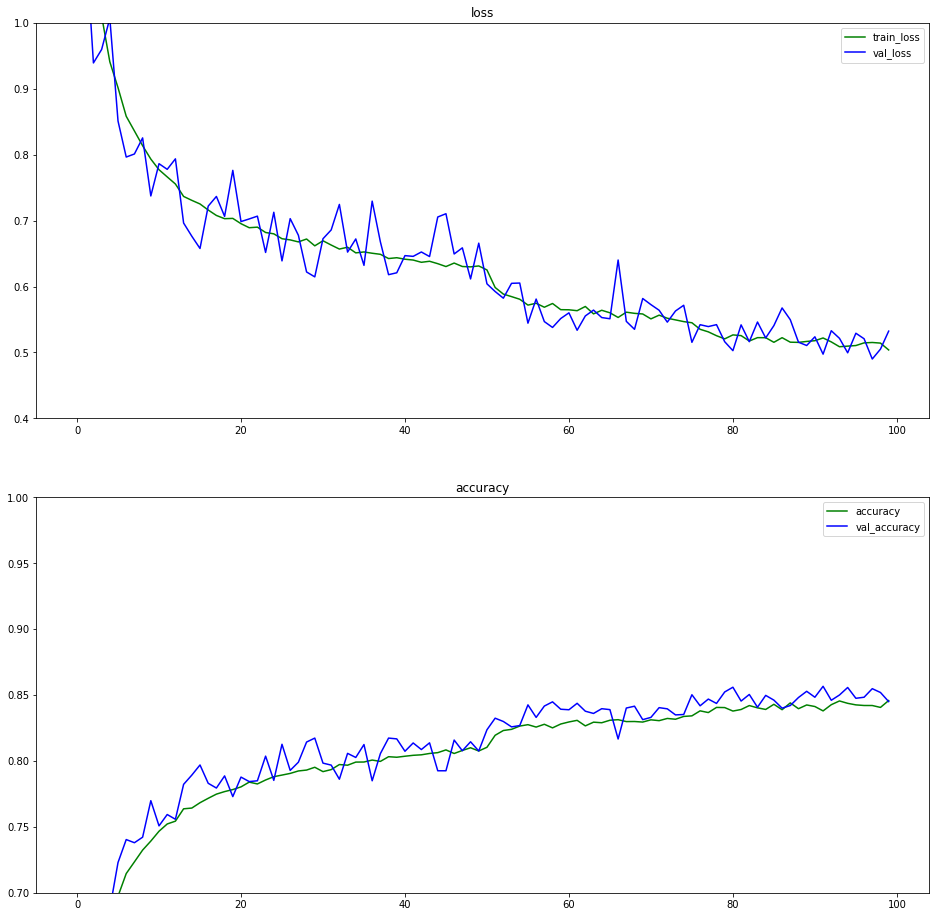

In [12]:
fig, ax = plt.subplots(2, 1, figsize=(16, 16))
ax[0].set_title("loss")
ax[0].plot(np.arange(epochs), model.history.history['loss'], 'g', label='train_loss')
ax[0].plot(np.arange(epochs), model.history.history['val_loss'], 'b', label='val_loss')
ax[0].set_ylim(0.4, 1)
ax[0].legend()

ax[1].set_title("accuracy")
ax[1].plot(np.arange(epochs), model.history.history['accuracy'], 'g', label='accuracy')
ax[1].plot(np.arange(epochs), model.history.history['val_accuracy'], 'b', label='val_accuracy')
ax[1].set_ylim(0.7, 1)
ax[1].legend()

### **Save model and weights**

In [0]:
# model.save(model_path)

# model_path

In [14]:
model = load_model(model_path)

model_path

'/content/saved_models/keras_cifar10_trained_model.h5'

### **Score trained model.**

In [15]:
scores = model.evaluate(x_test, y_test)

scores

313/313 [==============================] - 1s 4ms/step - loss: 0.4975 - accuracy: 0.8567


[0.4974817633628845, 0.8567000031471252]